In [1]:
import os
import sys
import torch
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import math

import import_ipynb
from Reservoir import Reservoir
from Model import ConvNet
from Trainer import Trainer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = "cpu"
print('using device', device)
torch.cuda.empty_cache()

importing Jupyter notebook from Reservoir.ipynb
importing Jupyter notebook from Model.ipynb
importing Jupyter notebook from Trainer.ipynb
using device cpu


In [2]:
torch.cuda.empty_cache()

In [3]:
dataset = Reservoir("./data/training/images/train-images-idx3-ubyte.gz",
                        "./data/training/labels/train-labels-idx1-ubyte.gz",
                        "./data/testing/images/t10k-images-idx3-ubyte.gz",
                        "./data/testing/labels/t10k-labels-idx1-ubyte.gz")
print("Data size", len(dataset.training_pool))

Total training stacks 5400
Total validation stacks 600
Total testing stacks 10000
Data size 60000


In [4]:
outputs = 10
image_shape = dataset.training_pool[0]['image'].reshape((1,28,28)).shape
net = ConvNet(outputs, image_shape).to(device)
#net = torch.load("snapshots/92_full_cnn.pt")
print("number of parameters: ", sum(p.numel() for p in net.parameters()))

units after conv 588
fc parameters:  5890
number of parameters:  5926


In [5]:
optimizer = optim.Adam(net.parameters(), amsgrad=True, weight_decay=0.01)
criterion = nn.CrossEntropyLoss() #don't use reduction!!!
trainer = Trainer(device, net, dataset, optimizer, criterion)


Epoch: 0
Training Loss: 0.22325
Validation Loss: 0.18246


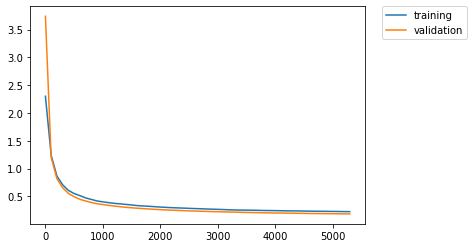


Epoch: 1
Training Loss: 0.14955
Validation Loss: 0.11847


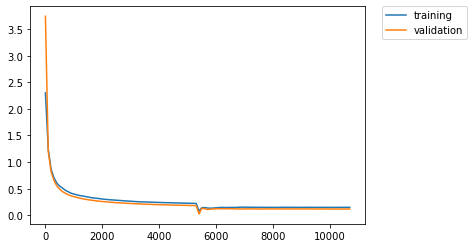


Epoch: 2
Training Loss: 0.14628
Validation Loss: 0.11579


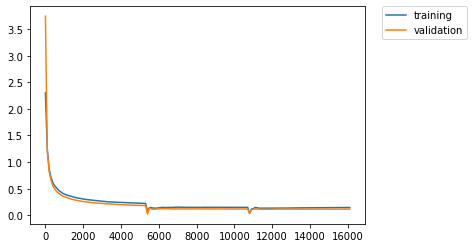

KeyboardInterrupt: 

In [6]:
epochs = 10
report_period = 100
trainer.fit(epochs, report_period)

In [ ]:
print(torch.cuda.max_memory_cached(device))
torch.cuda.empty_cache()
print(torch.cuda.memory_cached(device))

In [ ]:
from tqdm.notebook import tqdm_notebook
def test_accuracy(dataset):
    total = 0
    correct = 0

    net.eval()

    for i, batch in enumerate(dataset.testing_pool.testloader):
        image = batch['image'][0].float()
        image = np.transpose(image,(2,0,1))
        image = image.reshape(1,1,28,28).to(device).float()
        label = batch['label'][0]
        output = torch.argmax(net(image))

        if output.item() == label.item():
            correct += 1
        total += 1

    print("Total: "+str(total))
    print("Correct: "+str(correct))

    print("Percent Correct: {}%".format((correct/total)*100))

test_accuracy(dataset)

In [ ]:
# Visualize feature maps
"""
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

net.conv1.register_forward_hook(get_activation('conv1'))
net.conv2.register_forward_hook(get_activation('conv2'))
net.conv3.register_forward_hook(get_activation('conv3'))

def getActivations(name):
    act = activation[name].squeeze()
    act = act.cpu()
    act = act.detach().numpy()
    print("Convolution: "+name)
    print("Activation size: "+str(act.shape[1:]))

    nrows = 4
    ncols = 4
    
    fig, axarr = plt.subplots(nrows,ncols, figsize=(12, 4))
    for x in range(nrows):
        for y in range(ncols):
            axarr[x][y].imshow(act[ncols*x + y], cmap='gray')
    plt.show()
"""